In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import os
import shutil
from sklearn.model_selection import train_test_split

2024-12-02 19:34:51.075190: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733189691.276692    2038 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733189691.338172    2038 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 19:34:51.813173: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set Image directories
dataset_dir = '../dataset/images'
train_dir = '../dataset/train'
validation_dir = '../dataset/val'
test_dir = '../dataset/test'

In [3]:
# code just to create tesing directories

# Function to delete and recreate directories
def reset_directory(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)
    os.makedirs(directory, exist_ok=True)

# Reset train, validation, and test directories
reset_directory(train_dir)
reset_directory(validation_dir)
reset_directory(test_dir)

# Get all subdirectories (each representing a dog breed)
breed_dirs = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

print(f'Number of breeds: {len(breed_dirs)}')

# Iterate through each breed directory
for breed in breed_dirs:
    breed_path = os.path.join(dataset_dir, breed)
    images = [os.path.join(breed_path, img) for img in os.listdir(breed_path) if img.endswith(('jpg', 'jpeg', 'png'))]

    # Split the images into train, validation, and test sets
    train_images, temp_images = train_test_split(images, test_size=0.3, random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

    # Create breed directories in train, validation, and test directories
    os.makedirs(os.path.join(train_dir, breed), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, breed), exist_ok=True)
    os.makedirs(os.path.join(test_dir, breed), exist_ok=True)

    # Function to copy images to respective directories
    def copy_images(image_list, target_dir):
        for image_path in image_list:
            shutil.copy(image_path, os.path.join(target_dir, breed))

    # Copy images to train, validation, and test directories
    copy_images(train_images, train_dir)
    copy_images(val_images, validation_dir)
    copy_images(test_images, test_dir)

Number of breeds: 120


In [4]:
# Data generator functions (creates our dataset)
def create_datagen(preprocessing_function =""):
    return ImageDataGenerator(
        preprocessing_function=preprocessing_function,
        rescale=1./255  # Normalize pixel values
    )
def create_generator(datagen, directory, shuffle):
    return datagen.flow_from_directory(
        directory,
        target_size=(300,300),
        batch_size=16,
        class_mode='categorical',
        shuffle=shuffle,
    )

In [5]:
# Create data generators (datasets for validation, testing, and training)
datagen_nasnet = create_datagen(tf.keras.applications.vgg16.preprocess_input)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator_nasnet = create_generator(datagen_nasnet, train_dir, True)
val_generator = create_generator(val_datagen, validation_dir, True)
test_generator = create_generator(test_datagen, test_dir, False)

Found 14357 images belonging to 120 classes.
Found 3082 images belonging to 120 classes.
Found 3141 images belonging to 120 classes.


In [14]:
# Model Building
nasnet_model = tf.keras.applications.NASNetLarge(weights='imagenet', include_top=False, input_shape=(300,300,3))
x = nasnet_model.output
# Freeze base model layers
nasnet_model.trainable = False
# global average pooling layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# fully connected layer
x = tf.keras.layers.Dense(1024, activation='relu')(x)
# categorical classification (120 predicatable outputs)
x_preds = tf.keras.layers.Dense(120, activation='softmax')(x)
nasnet_model = tf.keras.Model(inputs=nasnet_model.input, outputs=x_preds)

In [7]:
nasnet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv1 (Conv2D) │ (None, 149, 149,  │      2,592 │ input_layer[0][0] │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn1            │ (None, 149, 149,  │        384 │ stem_conv1[0][0]  │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_conv_1_s… │ (None, 149, 149,  │      4,032 │ activation[0][0]  │
│ (Conv2D)            │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_bn_1_ste… │ (None, 149, 149,  │        168 │ reduction_conv_1… │
│ (BatchNormalizatio… │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 149, 149,  │          0 │ reduction_bn_1_s… │
│ (Activation)        │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 149, 149,  │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 153, 153,  │          0 │ activation_1[0][… │
│ (ZeroPadding2D)     │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 155, 155,  │          0 │ activation_3[0][… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 75, 75,    │      2,814 │ separable_conv_1… │
│ (SeparableConv2D)   │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 75, 75,    │      8,736 │ separable_conv_1… │
│ (SeparableConv2D)   │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 75, 75,    │        168 │ separable_conv_1… │
│ (BatchNormalizatio… │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 75, 75,    │        168 │ separable_conv_1… │
│ (BatchNormalizatio… │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 75, 75,    │          0 │ separable_conv_1… │
│ (Activation)        │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 75, 75,    │          0 │ separable_conv_1… │
│ (Activation)        │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_2_r… │ (None, 75, 75,    │      2,814 │ activation_2[0][

 Total params: 89,169,610 (340.16 MB)

 Trainable params: 4,252,792 (16.22 MB)

 Non-trainable params: 84,916,818 (323.93 MB)

In [16]:
from tensorflow.keras.optimizers import Adam
nasnet_model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
# Model Training
history = nasnet_model.fit(train_generator_nasnet, validation_data=val_generator, epochs=10)

Epoch 1/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 333s 339ms/step - accuracy: 0.3178 - loss: 4.1339 - val_accuracy: 0.8692 - val_loss: 1.9485
Epoch 2/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 276s 308ms/step - accuracy: 0.7832 - loss: 1.5150 - val_accuracy: 0.8988 - val_loss: 0.7744
Epoch 3/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 270s 300ms/step - accuracy: 0.8170 - loss: 0.7938 - val_accuracy: 0.9033 - val_loss: 0.5308
Epoch 4/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 262s 292ms/step - accuracy: 0.8259 - loss: 0.6372 - val_accuracy: 0.9030 - val_loss: 0.4502
Epoch 5/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 271s 302ms/step - accuracy: 0.8385 - loss: 0.5681 - val_accuracy: 0.9033 - val_loss: 0.4055
Epoch 6/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 284s 316ms/step - accuracy: 0.8454 - loss: 0.5242 - val_accuracy: 0.9036 - val_loss: 0.3861
Epoch 7/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 271s 302ms/step - accuracy: 0.8496 - loss: 0.4959 - val_accuracy: 0.9059 - val_loss: 0.3699
Epoch 8/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 292s 326ms/step - accuracy: 0.8577 -

 196/3141 ━━━━━━━━━━━━━━━━━━━━ 12:05 246ms/step - accuracy: 0.9010 - loss: 0.3700

2024-12-02 23:30:00.788776: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/astro/miniconda3/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


3141/3141 ━━━━━━━━━━━━━━━━━━━━ 55s 17ms/step - accuracy: 0.8977 - loss: 0.3870   
Test Loss: 0.3881283700466156
Test Accuracy: 0.8974848985671997
3141/3141 ━━━━━━━━━━━━━━━━━━━━ 72s 19ms/step   
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      0.96      0.98        28
           2       0.92      0.92      0.92        38
           3       0.95      0.87      0.91        23
           4       0.91      0.91      0.91        33
           5       0.94      1.00      0.97        29
           6       0.97      1.00      0.98        30
           7       1.00      0.85      0.92        26
           8       0.88      0.85      0.86        26
           9       0.97      1.00      0.99        36
          10       0.93      1.00      0.96        27
          11       0.86      0.83      0.85        30
          12       0.97      1.00      0.98        29
          13       1.00   

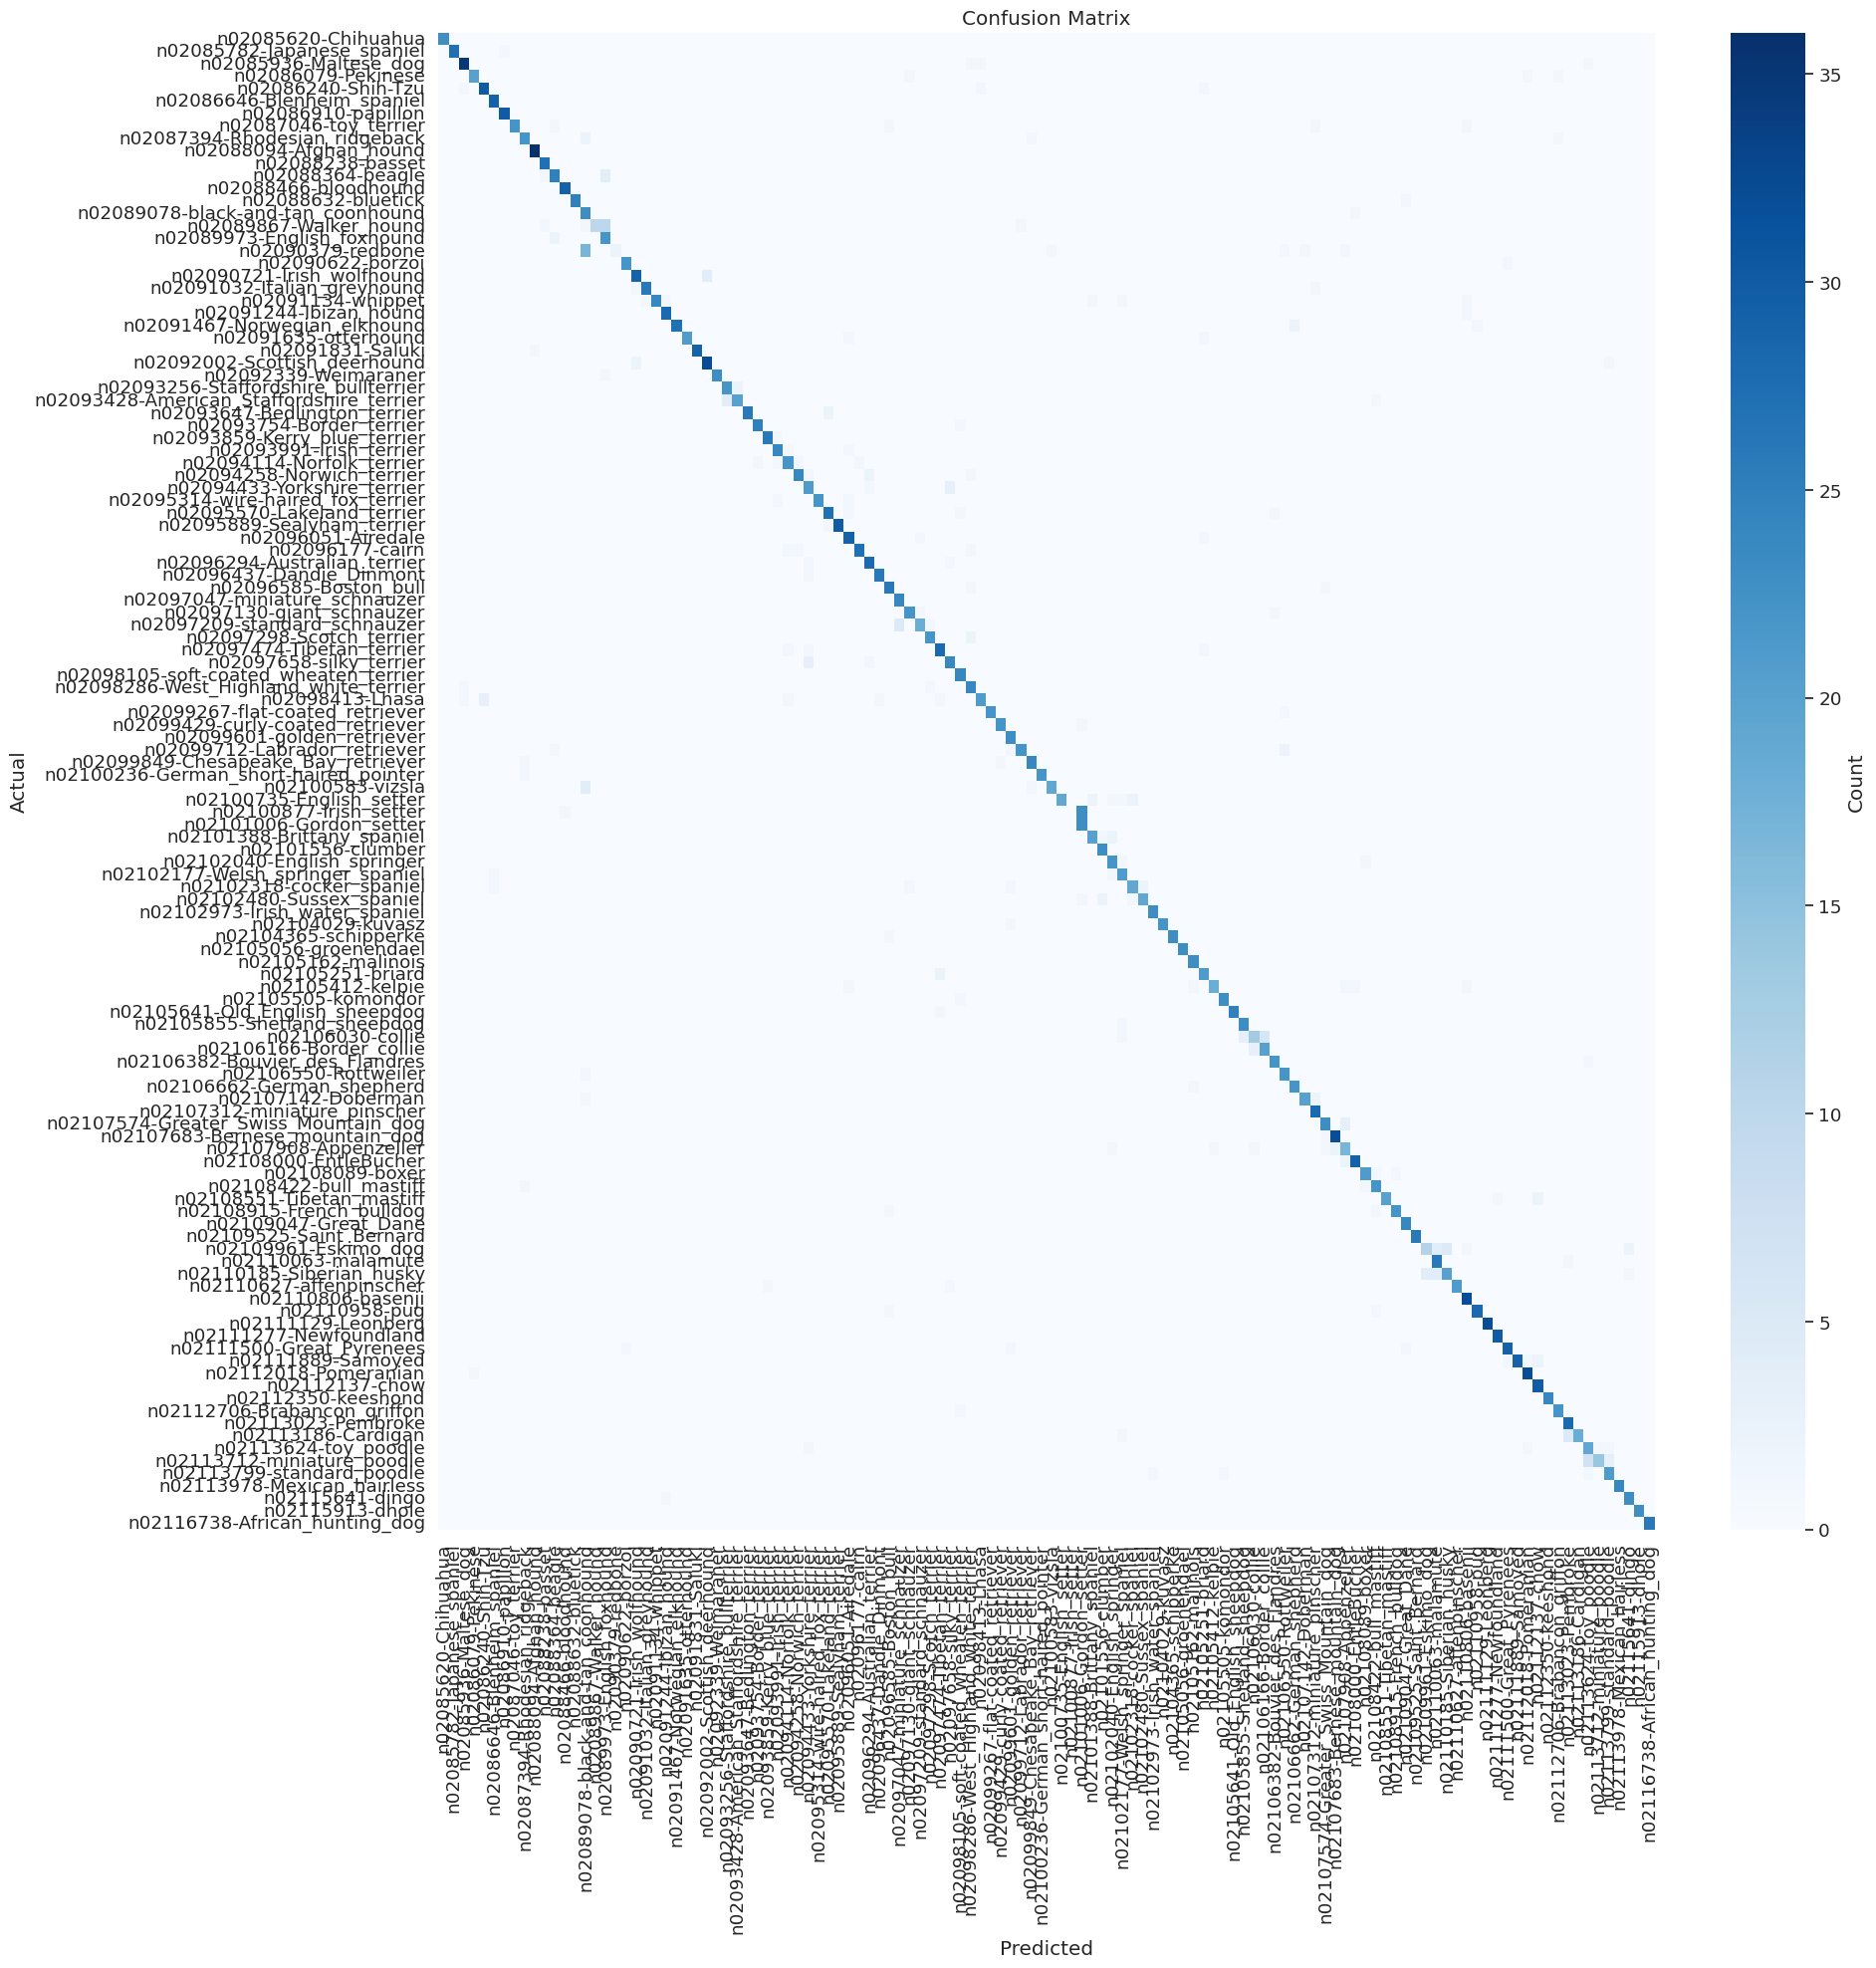

Calculated Accuracy from Confusion Matrix: 89.75%


In [18]:
# Evaluate the model on the test data
test_loss, test_acc = nasnet_model.evaluate(test_generator, steps=test_generator.classes.size)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

# Reset the test generator
test_generator.reset()

# Get the predictions
predictions = nasnet_model.predict(test_generator, steps=test_generator.classes.size)

# Get true labels
y_true = test_generator.classes

# Convert predicted probabilities to class labels
y_pred = predictions.argmax(axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, zero_division=1))

# Print confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
class_labels = list(test_generator.class_indices.keys())
print(class_labels)
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)
print("Confusion Matrix:")
print(conf_matrix_df)

# Set the size of the plot
plt.figure(figsize=(20, 20))

# Set the font scale
sns.set(font_scale=1.2)

# Create heatmap (confusion matrix)
sns.heatmap(conf_matrix_df, annot=False, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'}, xticklabels=True, yticklabels=True)

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')

plt.tight_layout()

plt.show()

# Calculate accuracy from confusion matrix
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
print(f"Calculated Accuracy from Confusion Matrix: {accuracy * 100:.2f}%")

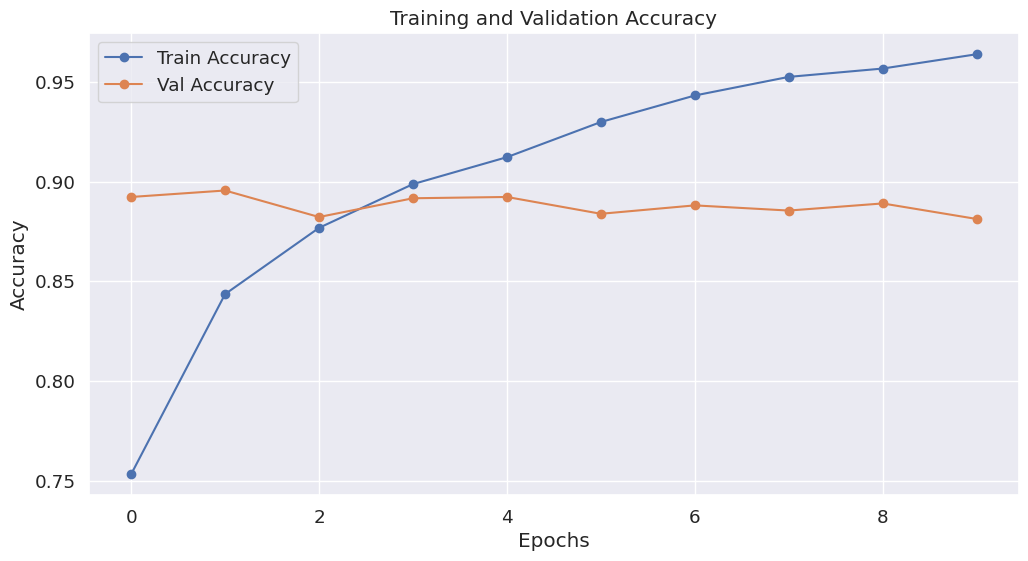

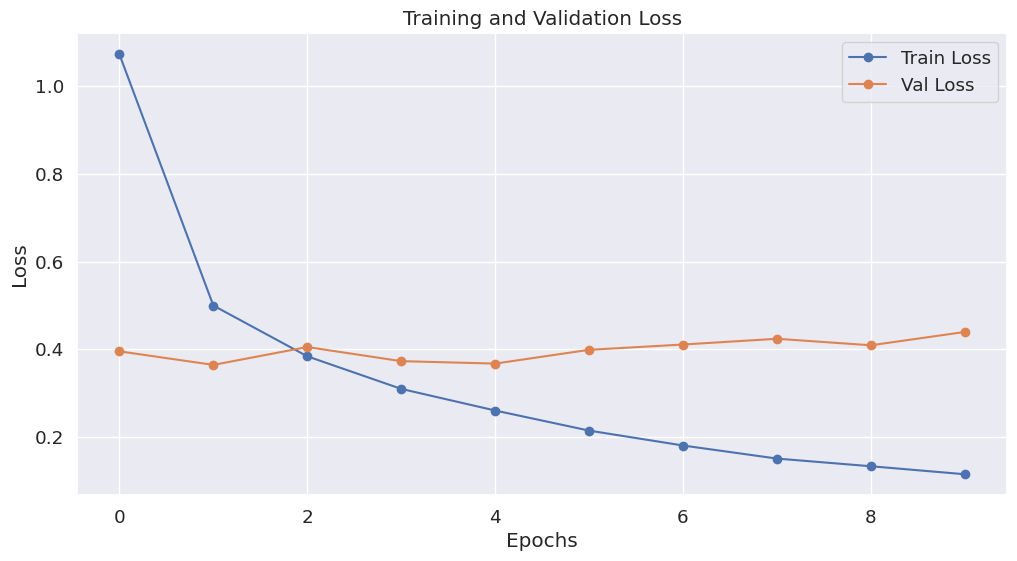

In [10]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.grid(True)
plt.show()